# Arrivalist Data  Challenge

Prompt:
How can we differentiate between good users versus bad users?

If we are to create a model to classify these users:
- what kind of features ought we construct from the data? How should we explore the data? 
- Can you identify users in this data that are noisy vs clean in terms of travel? 
- What other kinds of questions can/should you ask about the data?

This is an open ended problem. Please feel free to reach out if you have any questions.


In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')

In [3]:
import datetime as dt

In [214]:
import gc
gc.collect()

20

In [5]:
import geopandas as gpd
from geopy.distance import distance
import folium

## Read Data

In [9]:
df_travel = pd.read_csv('interview_data.csv')

/storage/home/lul165/.conda/envs/llyenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Description

In [10]:
df_travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16125354 entries, 0 to 16125353
Data columns (total 13 columns):
device_id       int64
ts              object
ts_date         object
ts_quarter      object
lat             float64
lon             float64
geohash5        object
country         object
region          object
city            object
zip_code        object
publisher_id    float64
partner_id      int64
dtypes: float64(3), int64(2), object(8)
memory usage: 1.6+ GB


In [11]:
df_travel.describe()

,device_id,lat,lon,publisher_id,partner_id
count,1.612535e+07,1.612535e+07,1.612535e+07,8.913284e+06,1.612535e+07
mean,2.020161e+03,3.717414e+01,-9.263365e+01,9.674115e+17,1.686466e+00
std,8.408644e+03,5.339480e+00,1.862537e+01,2.393162e+18,6.741262e-01
min,1.000000e+00,-3.807455e+01,-1.597172e+02,1.003000e+03,1.000000e+00
25%,2.050000e+02,3.397732e+01,-9.848565e+01,1.156000e+03,1.000000e+00
50%,3.720000e+02,3.796560e+01,-8.678347e+01,5.009000e+03,2.000000e+00
75%,8.790000e+02,4.036284e+01,-8.024539e+01,5.009000e+03,2.000000e+00
max,6.847600e+04,6.507238e+01,1.512167e+02,9.153270e+18,3.000000e+00


In [12]:
df_travel['device_id'].unique().shape

(1089,)

Total User number: 1089

In [13]:
df_travel.isna().any()

device_id       False
ts              False
ts_date         False
ts_quarter      False
lat             False
lon             False
geohash5        False
country         False
region          False
city            False
zip_code        False
publisher_id     True
partner_id      False
dtype: bool

## Small Sample Exploration
- Take Several Users

In [14]:
df_sp = df_travel[df_travel['device_id']<35]

In [15]:
## Convert string to timestamp
datetime = df_sp['ts'].apply(lambda x:dt.datetime.strptime(x,'%Y-%m-%d %X'))
datetime = datetime.rename('dt')

df_sp = pd.concat([df_sp,datetime],axis=1)

In [16]:
## Users included in the sample
df_sp['device_id'].unique()

array([ 1,  2,  6,  8, 11, 13, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 33])

In [17]:
## Some user has multiple publisher ID
df_sp[df_sp['device_id']==20]['publisher_id'].unique()

array([           nan, 1.15400000e+03, 1.15600000e+03, 1.14500000e+03,
       1.00300000e+03, 6.53079112e+18, 1.42934202e+18, 1.85157059e+17,
       5.25626457e+18, 4.12621294e+18, 8.99631425e+18, 3.49038444e+17,
       5.95568977e+17, 4.81777359e+18, 2.21523270e+17, 4.66213289e+18,
       2.38449931e+17, 8.43738976e+17, 8.11870489e+18, 3.25100000e+03,
       1.22540000e+04])

### Time-series Resampling

In [18]:
## Time-series Resampling for each user using a 5 mins sliding window
df_sp_rs = df_sp.set_index('dt').groupby('device_id').resample('5T').first().dropna(how='any', subset=['ts']) \
                                                     .drop(['device_id'],axis=1).reset_index()
df_sp_rs.describe()

,device_id,lat,lon,publisher_id,partner_id
count,136927.000000,136927.000000,136927.000000,1.022340e+05,136927.000000
mean,21.603022,40.349030,-96.621193,1.152882e+18,1.708056
std,9.076939,5.408635,16.375491,2.634618e+18,0.667808
min,1.000000,18.022799,-159.714760,1.003000e+03,1.000000
25%,19.000000,40.016790,-105.096820,1.172000e+03,1.000000
50%,23.000000,40.937790,-97.263480,5.009000e+03,2.000000
75%,31.000000,42.634204,-80.866290,5.009000e+03,2.000000
max,33.000000,47.978210,11.210057,8.996314e+18,3.000000


In [19]:
# df_sp_rs[]
df_sp_rs['device_id'].unique()

array([ 1,  2,  6,  8, 11, 13, 18, 19, 20, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 33])

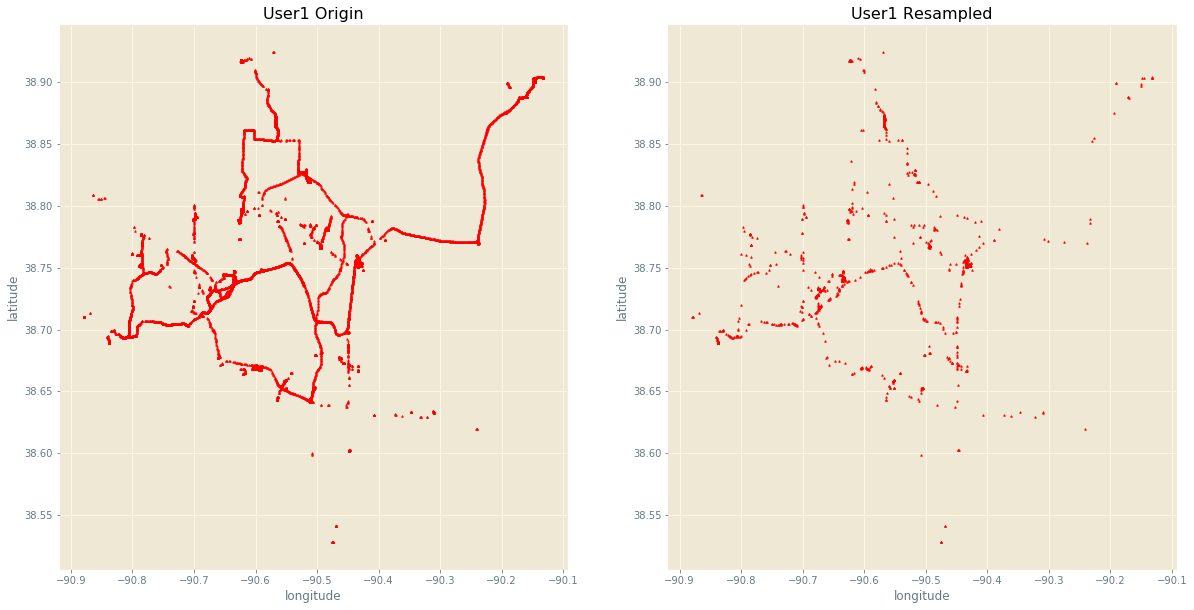

In [20]:
## Before and After resampling

fig = plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.scatter(df_sp[df_sp['device_id']==1]['lon'], df_sp[df_sp['device_id']==1]['lat'],s=2, marker='^',color='red')
plt.xlabel(r"longitude")
plt.ylabel(r"latitude")
plt.title('User1 Origin')

plt.subplot(1, 2, 2)
plt.scatter(df_sp_rs[df_sp_rs['device_id']==1]['lon'], df_sp_rs[df_sp_rs['device_id']==1]['lat'],s=2, marker='^',color='red')
plt.xlabel(r"longitude")
plt.ylabel(r"latitude")
plt.title('User1 Resampled')

plt.show()


In [21]:
from ipywidgets import interact, IntSlider,SelectionSlider,Dropdown

def plot_user_loc(userid,date_dis):
    plt.figure(figsize=(12,6))
#     plt.axes().set_aspect('equal')
    plt.subplot(1, 2, 1)
    plt.scatter(df_sp[(df_sp['device_id']==userid) & (df_sp['ts_date']==date_dis)]['lon'],
                df_sp[(df_sp['device_id']==userid) & (df_sp['ts_date']==date_dis)]['lat'],
                s=2, marker='^',color='red')    
    plt.xlabel(r"longitude")
    plt.ylabel(r"latitude")
    plt.title('User Origin')
    
    plt.subplot(1, 2, 2)
    plt.scatter(df_sp_rs[(df_sp_rs['device_id']==userid) & (df_sp_rs['ts_date']==date_dis)]['lon'],
                df_sp_rs[(df_sp_rs['device_id']==userid) & (df_sp_rs['ts_date']==date_dis)]['lat'],
                s=2, marker='^',color='red')    
    plt.xlabel(r"longitude")
    plt.ylabel(r"latitude")
    plt.title('User Resample')
    
interact(plot_user_loc, userid = Dropdown(description='User',options=list(df_sp['device_id'].unique())),
                        date_dis = SelectionSlider(description='date',
                                                   options=list(df_sp[df_sp['device_id']==1]['ts_date'].unique()),
                                                   style = {'description_width': 'initial'}))

interactive(children=(Dropdown(description='User', options=(1, 2, 6, 8, 11, 13, 18, 19, 20, 23, 24, 25, 26, 27…

<function __main__.plot_user_loc(userid, date_dis)>

### Data Cleaning
- Single user based
- For each point, compute the travel speed from previous point and to next point
- If any travel speed is unreasonable, tag current point an invalid point

In [22]:
## Create (lat,lon) tuple

df_sp_rs['lat_lon_3'] = df_sp_rs[['lat','lon']].apply(lambda x: (round(x.iloc[0],3),round(x.iloc[1],3)),axis=1)

In [23]:
# test = gp.get_group(6)

In [24]:
# row_iterator = test.iterrows()
# last = next(row_iterator)[1]
# travel_speed = pd.DataFrame(index=test.index,columns=['speed'])
# time = pd.DataFrame(index=test.index,columns=['time'])
# dist = pd.DataFrame(index=test.index,columns=['dist'])

# for i, row in row_iterator:

#     travel_speed.loc[i] = distance(row['lat_lon_3'],last['lat_lon_3']).km/((row['dt']-last['dt']).seconds)*3600
#     dist.loc[i] = distance(row['lat_lon_3'],last['lat_lon_3']).km
#     time.loc[i] = ((row['dt']-last['dt']).seconds)/3600
#     last = row
# test = test.join(travel_speed).join(dist).join(time)

In [25]:
from geopy.distance import distance
"""
One 0.001 decimal change in lat: about 111 meters

"""
coords_1 = (38.700,-90.471)
coords_2 = (38.701,-90.471)

print(distance(coords_1, coords_2).km)

0.11100977278453837


In [26]:
def tspeed_est(data):
    
    row_iter = data.iterrows()
    last = next(row_iter)[1]
    travel_speed = pd.DataFrame(index=data.index,columns=['time','dist','tspeed'])

    for i, row in row_iter:
        travel_speed.loc[i]['time'] = round(((row['dt']-last['dt']).seconds)/3600,4)
        travel_speed.loc[i]['dist'] = round(distance(row['lat_lon_3'],last['lat_lon_3']).km,4)
        
        try:
            travel_speed.loc[i]['tspeed'] = round(travel_speed.loc[i]['dist'] / travel_speed.loc[i]['time'],4)
        except:
            travel_speed.loc[i] = -999
            
        last = row    
        
    return travel_speed

In [27]:
gp = df_sp_rs.groupby('device_id')
temp = []
for key, data in gp:
    temp.append(tspeed_est(data))
ts = pd.concat(temp)
df_sp_rs = df_sp_rs.join(ts)

In [28]:
## Check the quantile of nosiy data
df_sp_rs['tspeed'].quantile(0.00001), df_sp_rs['tspeed'].quantile(0.999)

(-999.0, 506.1245409003691)

In [29]:
index_an = df_sp_rs[(df_sp_rs['tspeed']<0)|(df_sp_rs['tspeed']>1000)].index
index_an = index_an.append(index_an-1)

In [30]:
df_sp_rs.iloc[np.sort(index_an)][0:5]

,device_id,dt,ts,ts_date,ts_quarter,lat,lon,geohash5,country,region,city,zip_code,publisher_id,partner_id,lat_lon_3,time,dist,tspeed
12616,8,2018-02-26 13:20:00,2018-02-26 13:21:10,2018-02-26,2018-01-01,30.927619,-81.685925,djmzv,usa,ga,woodbine,31569,1172.0,2.0,"(30.928, -81.686)",1,19.5038,19.5038
12617,8,2018-02-26 13:25:00,2018-02-26 13:27:10,2018-02-26,2018-01-01,31.651889,-81.392975,djwh5,usa,ga,riceboro,31323,1172.0,2.0,"(31.652, -81.393)",0.0833,84.9825,1020.2
12999,8,2018-03-14 22:55:00,2018-03-14 22:58:06,2018-03-14,2018-01-01,40.242400,-75.636700,dr4hy,usa,pa,pottstown,19464,NaN,2.0,"(40.242, -75.637)",0.6667,456.62,684.895
13000,8,2018-03-14 23:15:00,2018-03-14 23:15:56,2018-03-14,2018-01-01,41.294481,-80.866084,dpq6z,usa,oh,warren,44483,1172.0,2.0,"(41.294, -80.866)",0.3333,456.595,1369.92
14179,8,2018-05-04 13:45:00,2018-05-04 13:49:42,2018-05-04,2018-04-01,44.999400,-93.297000,9zvxu,usa,mn,minneapolis,55411,1154.0,1.0,"(44.999, -93.297)",1.75,1090.33,623.046


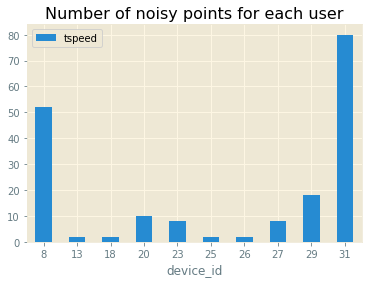

In [31]:
df_sp_rs.iloc[np.sort(index_an)][['device_id','tspeed']].groupby('device_id').count() \
                                                        .plot.bar(rot=0,title='Number of noisy points for each user')

In [32]:
## Drop these noisy values
df_sp_rs = df_sp_rs[(df_sp_rs['tspeed'] >= 0) & (df_sp_rs['tspeed'] < 1000)]

In [33]:
## Create necessary column for future analysis

df_sp_rs['year'] = df_sp_rs['dt'].map(lambda x: x.year)
df_sp_rs['month'] = df_sp_rs['dt'].map(lambda x: x.month)
df_sp_rs['day'] = df_sp_rs['dt'].map(lambda x: x.day)
df_sp_rs['weekday'] = df_sp_rs['dt'].map(lambda x: x.weekday())
df_sp_rs['week'] = df_sp_rs['dt'].map(lambda x: x.week)
df_sp_rs['date'] = df_sp_rs['dt'].map(lambda x: x.date())

### Stay Point Detection

In [34]:
## Specify a stop duration defination:{'1': 5 mins}

stop_dur = 1

df_sp_stop = df_sp_rs[['device_id','date','lat_lon_3','dt']] \
                                            .groupby(['device_id','date','lat_lon_3']).count().reset_index()
df_sp_stop = df_sp_stop.drop(df_sp_stop[df_sp_stop['dt']<=stop_dur].index).reset_index() \
                                            .rename(columns={'lat_lon_3':'stop_point','dt':'stop_freq'})

df_sp_stop['mon_fri'] = df_sp_stop['date'].map(lambda x: (x.weekday() < 5)*1)

df_sp_stop[0:5]

,index,device_id,date,stop_point,stop_freq,mon_fri
0,1,1,2018-01-02,"(38.733, -90.674)",4,1
1,4,1,2018-01-03,"(38.733, -90.674)",5,1
2,9,1,2018-01-03,"(38.793, -90.595)",2,1
3,11,1,2018-01-04,"(38.733, -90.674)",3,1
4,19,1,2018-01-05,"(38.753, -90.435)",2,1


In [74]:
def plot_stay_point(userid,date_dis):
    
    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(1, 2, 1)
  
 
    ax1.scatter(df_sp_rs[(df_sp_rs['device_id']==userid) & (df_sp_rs['date']==date_dis)]['lon'],
                    df_sp_rs[(df_sp_rs['device_id']==userid) & (df_sp_rs['date']==date_dis)]['lat'],
                     s = 2, marker='^',color='red')  
    plt.xlabel(r"longitude")
    plt.ylabel(r"latitude")
    plt.title('User Resampled')
    
#     plt.subplot(1, 2, 2)
    
    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1,sharey=ax1) 
    pointlist = list(zip(*df_sp_stop[(df_sp_stop['device_id']==userid) & (df_sp_stop['date']==date_dis)]['stop_point']))
    
   
    ax2.scatter(list(pointlist[1]),list(pointlist[0]), s=30, marker='o',color='blue')  
    plt.xlabel(r"longitude")
    plt.ylabel(r"latitude")
    plt.title('User Stay Point')
    
interact(plot_stay_point, userid = Dropdown(description='User',options=list(df_sp_stop['device_id'].unique())),
                        date_dis = SelectionSlider(description='ts_date',
                                                   options=list(df_sp_stop[df_sp_stop['device_id']==1]['date'].unique()),
                                                   style = {'description_width': 'initial'}))

interactive(children=(Dropdown(description='User', options=(1, 2, 6, 8, 11, 13, 18, 19, 20, 23, 24, 25, 26, 27…

<function __main__.plot_stay_point(userid, date_dis)>

In [36]:
## Aggregate the stop point number per day

df_sp_stopnum = df_sp_stop[['device_id','date','mon_fri','stop_point']].groupby(['device_id','date']) \
                                                            .agg({'stop_point':'count','mon_fri':'first'})\
                                                            .rename(columns={'stop_point':'stop_point_num'}).reset_index()
df_sp_stopnum[0:5]

,device_id,date,stop_point_num,mon_fri
0,1,2018-01-02,1,1
1,1,2018-01-03,2,1
2,1,2018-01-04,1,1
3,1,2018-01-05,1,1
4,1,2018-01-06,4,0


## User-based feature engineering

### 1. Location-based Features

** Stay point feature**
- Average stay points during weekend / weekend

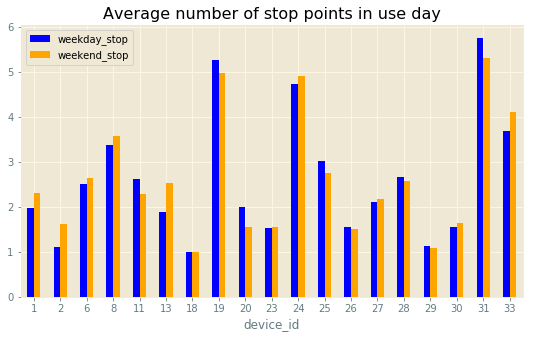

In [50]:
df_sp_userstop = df_sp_stopnum[df_sp_stopnum['mon_fri']==1][['device_id','stop_point_num']].groupby('device_id').mean() \
                                                            .rename(columns={'stop_point_num':'weekday_stop'}) \
                .join(df_sp_stopnum[df_sp_stopnum['mon_fri']==0][['device_id','stop_point_num']].groupby('device_id').mean() \
                                                            .rename(columns={'stop_point_num':'weekend_stop'}) )
df_sp_userstop.plot.bar(rot=0,title='Average number of stop points in use day',color = ['blue','orange'],figsize=(9,5))  

In [212]:
df_sp_userstop [0:5]

,weekday_stop,weekend_stop
device_id,,
1,1.971429,2.318182
2,1.100000,1.625000
6,2.500000,2.647059
8,3.386973,3.588235
11,2.610526,2.281250


### 2. Time-based features

**Daily Frequency - Average App Exporsure**
- Data collection frequency / App user frequency
- measureing user's exposure to Apps.

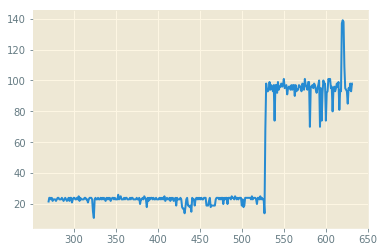

In [37]:
## User 8 useage frequency vs. use-day
df_daggre_sp = df_sp_rs[['device_id','date','ts']].groupby(['device_id','date']).count().reset_index()
plt.plot(df_daggre_sp[df_daggre_sp['device_id']==8]['ts'])

**Daily usage frquency **
- Average Data collection frequency to (end date - start date)

In [150]:
# Daily usage frquency (at a 5 min pace) of the period when data were collected
user_freq = pd.DataFrame(df_sp_rs[['device_id','dt']].groupby('device_id')['dt'] \
                         .apply(lambda x: x.count() / ((x.max() - x.min()).days + 1))) \
                         .rename(columns = {'dt':'avg_daily_freq'})

**Use Day Frequency**
- Average Data collection frequency for each use day (exposed days)

In [151]:
## Average use-day frequency
freq_day = df_sp_rs[['device_id','ts_date','ts']].groupby(['device_id','ts_date']).count().groupby('device_id').mean() \
                                                 .rename(columns={'ts':'avg_useday_freq'})

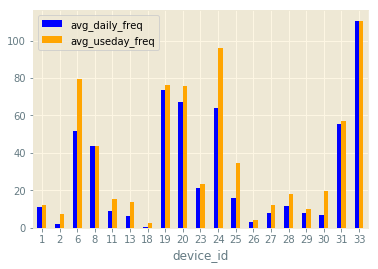

In [154]:
user_freq = user_freq.join(freq_day)
user_freq.plot.bar(rot=0,color=['blue','orange'])

### Autocorrelation

Time-series Feature: autocorrelation of use day frequency
- Correlation of app using (GPS exposure) vs the time?
- Indicated the app exposure pattern

In [41]:
df_user1 = df_sp_rs[['device_id','ts_date','ts']].groupby(['device_id','ts_date']).count().reset_index()

In [42]:
df_sp_freq = df_sp_rs[['device_id','date','dt']].groupby(['device_id','date']).count() \
                                   .rename(columns={'dt':'useday_freq'}).reset_index()

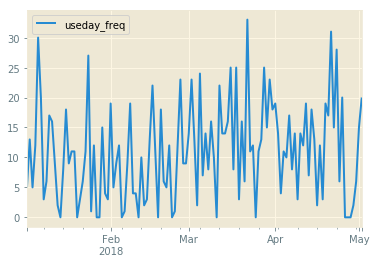

In [43]:
df_user1 = df_sp_freq[df_sp_freq['device_id']==1].set_index('date')
idx = pd.date_range(min(df_user1.index), max(df_user1.index))
df_user1 = df_user1.drop('device_id',axis=1).reindex(idx, fill_value=0)
df_user1.plot()

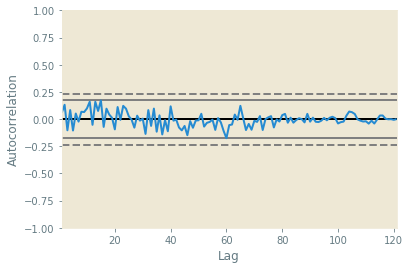

In [44]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_user1)

In [45]:
from statsmodels.tsa.ar_model import AR
ar_model = AR(df_user1).fit()

print('Lag: {}' .format(ar_model.k_ar))
# print('Coefficients: {}'. format(ar_model.params))

Lag: 13


Function to extract autoregressive parameter for each user

In [46]:
from statsmodels.tsa.ar_model import AR

def autoregress(data):
    data = data[['date','use_freq']].set_index('date')
    idx = pd.date_range(min(data.index), max(data.index))
    data = data.reindex(idx, fill_value=0)
    
    ar_model = AR(data).fit()
    return ar_model.k_ar

In [47]:
df_sp_auto = df_sp_rs[['device_id','date','dt']].groupby(['device_id','date']).count() \
                                                .rename(columns={'dt':'use_freq'}).reset_index()
group = df_sp_auto.groupby('device_id')

In [48]:
user_autolag = pd.DataFrame(index=user_freq.index)
lag_list = []
for key, data in group:
    lag_list.append(autoregress(data))
user_autolag['auto_lag'] = np.array(lag_list)

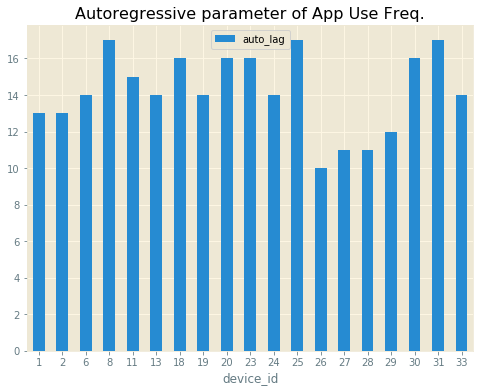

In [49]:
user_autolag.plot.bar(rot=0,figsize=(8,6),title='Autoregressive parameter of App Use Freq.')

### 3. Activity-based features

Are there any intertional travelers?

In [52]:
df_travel[df_travel['country']=='usa']['device_id'].unique().shape, \
df_travel[df_travel['country']!='usa']['device_id'].unique().shape, \
df_travel['device_id'].unique().shape

((1088,), (174,), (1089,))

** International, Domestic, Local Traveler**
- Ineternational / regionwide / citywide traveler / local traveler
- Significant difference in travel behaviors and customer value
- Help identify marketing target

In [53]:
## Given region and period, return average frquency of regionwide travel for each user
def traveler_type_agg(df,reg,pd):
    """
    pass in: dataframe, region: ['country','region','city'], period: ['year','month','week']
    output: dataframe of user regionwide travel frequency of specified period
    """
    avg_reg_pd = df.groupby(['device_id',pd])[reg].nunique() \
                .reset_index()[['device_id',reg]].groupby('device_id').mean() \
                .rename(columns = {reg:'avg_{}_{}'.format(reg,pd)})
    
    return avg_reg_pd

In [62]:
## Develop regionwide travel frquency features

travel_agg = []
for region in ['country','region','city']:
    for period in ['year','month','week']:
        travel_agg.append(traveler_type_agg(df_sp_rs,region,period))

In [63]:
travel_type = pd.concat(travel_agg,axis=1)
travel_type.shape

(19, 9)

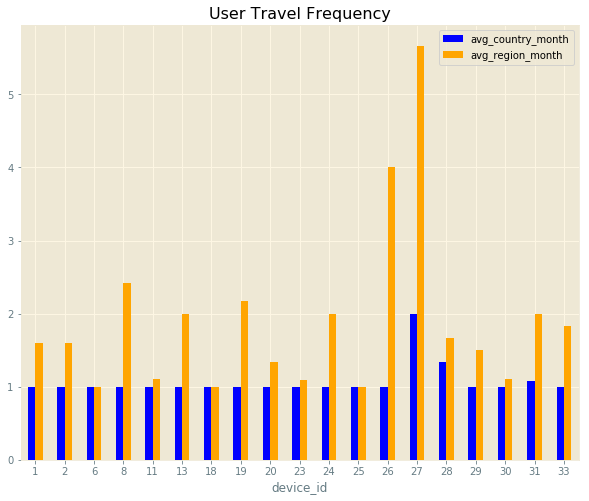

In [66]:
travel_type[['avg_country_month','avg_region_month']].plot.bar(
                                                                            rot=0,title='User Travel Frequency',
                                                                            color = ['blue','orange'],figsize=(10,8))  

## User-based Feature Summary

**1. Location-based features**
- Average Stay Point numbers

**2. Time-based features**
- Mobile App use frequency
- Autocorrelation parameter for App exposure

**3. Activity-based features**
- Travel type: International / statewide / citywide travel frequency

In [211]:
user_features_sp = pd.concat([user_freq,user_autolag,df_sp_userstop,travel_type],axis=1)
user_features_sp[0:5]

,avg_daily_freq,avg_useday_freq,auto_lag,weekday_stop,weekend_stop,avg_country_year,avg_country_month,avg_country_week,avg_region_year,avg_region_month,avg_region_week,avg_city_year,avg_city_month,avg_city_week
device_id,,,,,,,,,,,,,,
1,11.125000,12.361111,13,1.971429,2.318182,1,1.0,1.0,2,1.600000,1.666667,18,11.200000,8.833333
2,1.789809,7.205128,13,1.100000,1.625000,1,1.0,1.0,4,1.600000,1.153846,38,10.200000,4.692308
6,51.597884,79.284553,14,2.500000,2.647059,1,1.0,1.0,1,1.000000,1.000000,3,1.333333,1.100000
8,43.539726,43.779614,17,3.386973,3.588235,1,1.0,1.0,10,2.416667,1.500000,131,21.666667,7.250000
11,8.985612,15.139394,15,2.610526,2.281250,1,1.0,1.0,2,1.100000,1.031250,30,11.100000,9.468750


## Full Data Processing

In [83]:
now = dt.datetime.now()
end = dt.datetime.now()
print('This part takes:{}'.format(end-now))

This part takes:0:00:00.000067


In [84]:
## Time-series resampling
now = dt.datetime.now()

datetime = df_travel['ts'].apply(lambda x:dt.datetime.strptime(x,'%Y-%m-%d %X'))
datetime = datetime.rename('dt')
df_travel = pd.concat([df_travel,datetime],axis=1)

df_travel_rs = df_travel.set_index('dt').groupby('device_id').resample('5T').first().dropna(how='any', subset=['ts']) \
                                                     .drop(['device_id'],axis=1).reset_index()
    
df_travel_rs['lat_lon_3'] = df_travel_rs[['lat','lon']].apply(lambda x: (round(x.iloc[0],3),round(x.iloc[1],3)),axis=1)

end = dt.datetime.now()
print('This part takes:{}'.format(end-now))

This part takes:0:11:22.274075


In [ ]:
## Data Cleaning
now = dt.datetime.now()

gp = df_travel_rs.groupby('device_id')
temp = []
for key, data in gp:
    temp.append(tspeed_est(data))
ts = pd.concat(temp)

df_travel_rs = df_travel_rs.join(ts)
df_travel_rs['tspeed'] = df_travel_rs['tspeed'].fillna(0)
df_travel_rs = df_travel_rs[(df_travel_rs['tspeed'] >= 0) & (df_travel_rs['tspeed'] < 1000)]

end = dt.datetime.now()
print('This part takes:{}'.format(end-now))

In [ ]:
# df_travel_rs_2 = df_travel_rs.join(ts)
# df_travel_rs_2['tspeed'] = df_travel_rs_2['tspeed'].fillna(0)
# df_travel_rs_2 = df_travel_rs_2[(df_travel_rs_2['tspeed'] >= 0) & (df_travel_rs_2['tspeed'] < 1000)]
# df_travel_rs = df_travel_rs.loc[df_travel_rs_2.index]

In [122]:
now = dt.datetime.now()

df_travel_rs.to_csv('df_travel_resampled_cleaned.csv')

end = dt.datetime.now()
print('This part takes:{}'.format(end-now))

This part takes:0:01:04.660567


In [210]:
df_travel_rs.describe()

,device_id,lat,lon,publisher_id,partner_id,year,month,day,weekday,week
count,2.362084e+06,2.362084e+06,2.362084e+06,1.583722e+06,2.362084e+06,2362084.0,2.362084e+06,2.362084e+06,2.362084e+06,2.362084e+06
mean,2.442589e+03,3.699709e+01,-9.090114e+01,1.072985e+18,1.804065e+00,2018.0,5.512877e+00,1.551342e+01,2.953572e+00,2.206739e+01
std,9.369030e+03,5.427207e+00,2.029332e+01,2.506577e+18,6.371639e-01,0.0,3.485315e+00,8.750869e+00,1.979889e+00,1.517203e+01
min,1.000000e+00,-3.807455e+01,-1.597148e+02,1.003000e+03,1.000000e+00,2018.0,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
25%,2.580000e+02,3.386003e+01,-9.781291e+01,1.156000e+03,1.000000e+00,2018.0,3.000000e+00,8.000000e+00,1.000000e+00,9.000000e+00
50%,4.300000e+02,3.819935e+01,-8.637135e+01,2.748000e+03,2.000000e+00,2018.0,5.000000e+00,1.600000e+01,3.000000e+00,1.800000e+01
75%,1.082000e+03,4.035996e+01,-8.091618e+01,5.009000e+03,2.000000e+00,2018.0,9.000000e+00,2.300000e+01,5.000000e+00,3.500000e+01
max,6.847600e+04,6.507238e+01,1.512167e+02,9.153270e+18,3.000000e+00,2018.0,1.200000e+01,3.100000e+01,6.000000e+00,5.200000e+01


In [88]:
## Create datetime columns    
now = dt.datetime.now()

df_travel_rs['year'] = df_travel_rs['dt'].map(lambda x: x.year)
df_travel_rs['month'] = df_travel_rs['dt'].map(lambda x: x.month)
df_travel_rs['day'] = df_travel_rs['dt'].map(lambda x: x.day)
df_travel_rs['weekday'] = df_travel_rs['dt'].map(lambda x: x.weekday())
df_travel_rs['week'] = df_travel_rs['dt'].map(lambda x: x.week)
df_travel_rs['date'] = df_travel_rs['dt'].map(lambda x: x.date())

end = dt.datetime.now()
print('This part takes:{}'.format(end-now))

This part takes:0:00:46.192945


In [124]:
## Stay Point DataFrame
now = dt.datetime.now()

## Select a time-interval for stay duration: stop_dur 1 = 5 min, means filter the point that only stop <=5 mins per day
stop_dur = 1

## User-Stay point DataFrame, keep it for future analysis
df_travel_stop = df_travel_rs[['device_id','date','lat_lon_3','dt']] \
                                            .groupby(['device_id','date','lat_lon_3']).count().reset_index()
df_travel_stop = df_travel_stop.drop(df_travel_stop[df_travel_stop['dt']<=stop_dur].index).reset_index() \
                                            .rename(columns={'lat_lon_3':'stop_point','dt':'stop_freq'})

df_travel_stop['mon_fri'] = df_travel_stop['date'].map(lambda x: (x.weekday() < 5)*1)

## User-Daily Stay point number DataFrame
df_travel_stopnum = df_travel_stop[['device_id','date','mon_fri','stop_point']].groupby(['device_id','date']) \
                                                            .agg({'stop_point':'count','mon_fri':'first'})\
                                                            .rename(columns={'stop_point':'stop_point_num'}).reset_index()

## User average weekday and weekend Stay point Dataframe
df_travel_userstop = df_travel_stopnum[df_travel_stopnum['mon_fri']==1][['device_id','stop_point_num']] \
                                .groupby('device_id').mean().rename(columns={'stop_point_num':'weekday_stop'})\
                                    .join(df_travel_stopnum[df_travel_stopnum['mon_fri']==0][['device_id','stop_point_num']] \
                                        .groupby('device_id').mean().rename(columns={'stop_point_num':'weekend_stop'})).fillna(0)

end = dt.datetime.now()
print('This part takes:{}'.format(end-now))

This part takes:0:00:02.949591


In [125]:
## App use frequency: On use days and daily
now = dt.datetime.now()

## Average daily app use frquency
user_freq = pd.DataFrame(df_travel_rs[['device_id','dt']].groupby('device_id')['dt'] \
                         .apply(lambda x: x.count() / ((x.max() - x.min()).days + 1))) \
                         .rename(columns = {'dt':'avg_daily_freq'})

## Average app use frquency at a use day
freq_day = df_travel_rs[['device_id','date','ts']].groupby(['device_id','date']).count().groupby('device_id').mean() \
                                                 .rename(columns={'ts':'avg_useday_freq'})
user_freq = user_freq.join(freq_day)

end = dt.datetime.now()
print('This part takes:{}'.format(end-now))

This part takes:0:00:01.055082


In [94]:
"""
App use frequency autocorrelation parameter
Not implemeted yet
"""
# ## App use autocorrelation parameter
# now = dt.datetime.now()

# df_travel_auto = df_travel_rs[['device_id','date','dt']].groupby(['device_id','date']).count() \
#                                                 .rename(columns={'dt':'use_freq'}).reset_index()
# group = df_travel_auto.groupby('device_id')

# user_autolag = pd.DataFrame(index=user_freq.index)
# lag_list = []
# for key, data in group:
#     lag_list.append(autoregress(data))
# user_autolag['auto_lag'] = np.array(lag_list)

# end = dt.datetime.now()
# print('This part takes:{}'.format(end-now))

In [126]:
## Travel Type
now = dt.datetime.now()

travel_agg = []
for region in ['country','region','city']:
    for period in ['year','month','week']:
        travel_agg.append(traveler_type_agg(df_travel_rs,region,period))
travel_type = pd.concat(travel_agg,axis=1)

end = dt.datetime.now()
print('This part takes:{}'.format(end-now))

This part takes:0:00:14.753622


In [128]:
## Union all features
user_features_travel = pd.concat([user_freq,df_travel_userstop,travel_type],axis=1)
# ,user_autolag
user_features_travel.shape

(1089, 13)

In [165]:
user_features_travel.describe()

,avg_daily_freq,avg_useday_freq,weekday_stop,weekend_stop,avg_country_year,avg_country_month,avg_country_week,avg_region_year,avg_region_month,avg_region_week,avg_city_year,avg_city_month,avg_city_week
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,8.838781,14.128378,1.721685,1.620797,1.146924,1.015388,1.004997,2.738292,1.365889,1.140949,20.329660,5.683900,2.929240
std,18.725428,23.651985,1.266565,1.183291,0.511353,0.081093,0.030238,2.467884,0.644666,0.274413,54.266098,13.525409,4.988921
min,0.020772,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.511494,2.588957,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.444444,1.166667
50%,1.421875,4.465753,1.179775,1.166667,1.000000,1.000000,1.000000,2.000000,1.142857,1.041667,7.000000,2.400000,1.538462
75%,7.692982,13.953125,1.772358,1.800000,1.000000,1.000000,1.000000,3.000000,1.500000,1.176471,17.000000,5.000000,2.688889
max,139.800000,183.716763,9.714286,9.239583,11.000000,2.000000,1.571429,28.000000,11.333333,4.942308,1253.000000,271.833333,97.583333


## Naive K-means clustering

**A preliminary K-means clustering to reveal some user classes**

In [166]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [169]:
scaler.fit(user_features_travel)

StandardScaler(copy=True, with_mean=True, with_std=True)

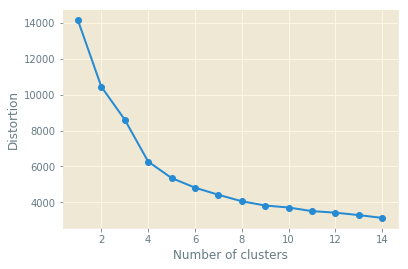

In [171]:
## Pick k of Kmeans
X = scaler.transform(user_features_travel)
distortions = []
for i in range(1, 15):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

Pick k = 6 according to the graph


In [172]:
kmeans = KMeans(
        n_clusters=6, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )

In [183]:
## Kmeans pipeline to clustering users 
kmeans_pipe = Pipeline([
    ('StandardizeScaler',scaler), 
    ('Kmeans',kmeans)
])
cluster_result = kmeans_pipe.fit(user_features_travel)

In [189]:
cluster_result.steps[1][1].labels_

array([4, 4, 3, ..., 2, 2, 2], dtype=int32)

In [190]:
user_features_travel['km_cluster'] = cluster_result.steps[1][1].labels_

In [194]:
import matplotlib.cm as cm
r1 = np.arange(6)
bar_data = user_features_travel.groupby('km_cluster').mean()

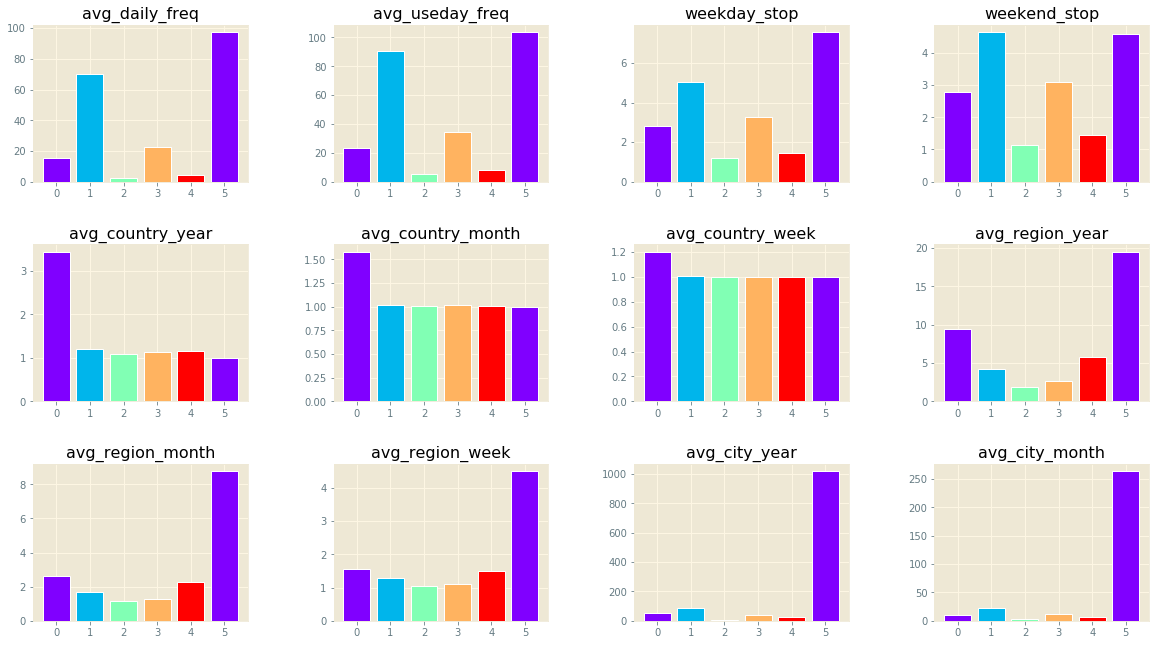

In [200]:
fig = plt.figure(figsize=(20,15))

fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 13):
    ax = fig.add_subplot(4, 4, i)
    ax.bar(r1, bar_data.iloc[:,i-1], width=0.8, edgecolor='white', color=cm.rainbow(np.linspace(0, 1, 6)))
    ax.title.set_text(bar_data.columns.values[i-1])


### Clustering Result


**Findings:**
1. More users' stay points are detected for high frequency app users. - Group 1 vs 5
2. High frequency app usage + citywide or local travelers = more stay oints could be detected - Group 1
3. International travelers get fewer mobile apps usage, They tends to be busy workers.  - Group 0
4. US statewide travelers tends to have more weekday stay points than local traveler -Group 0 vs Group 1
5. More variation in the data for US statewide travelers. - Graph 7 

**Summary:** 

- **Good User**: 
    The ideal user for us are the users who use the mobile frequently. 
    More stay points could be detected from them, so it's easier to model their travel patterns. 
    Their user value is comparably higher to us. (Group 1 and 5)
    
- **Bad User**:
    In contrast, low app use frequency users have less value to us, they don’t have much exposure to the Mobile Ads. Also their data are sparse.
- **Fairly Good Users**
    For international travelers, their app use frequency is not high, but they have a fair amount of stay point detected. Due to the countrywide travel frequency, they might have high value to our clients for marketing. (Group 0)
    

## Future Work Direction

**1. Construction trip chain for each user based on time-ordered stay points**
- 3D Clustering (lat, long, time) 

**2. User Trip Activity Exploration**
- get the geospatial info and land use for user stay points


- Build User Profile according to the trip chain and location features
-- eg. Users #31

In [158]:
# df_sp_stop[df_sp_stop['dt']>33]

userid = 31
df_sp_stayagg_mf = df_sp_stop[df_sp_stop['mon_fri']==1].groupby(['device_id','stop_point'])\
                                                       .agg({'date':'count','stop_freq':'sum'}).reset_index()
df_stayagg_mf_user = df_sp_stayagg_mf[df_sp_stayagg_mf['device_id']==userid].nlargest(5,'stop_freq')

df_sp_stayagg_wk = df_sp_stop[df_sp_stop['mon_fri']==0].groupby(['device_id','stop_point'])\
                                                       .agg({'date':'count','stop_freq':'sum'}).reset_index()  
df_stayagg_wk_user= df_sp_stayagg_wk[df_sp_stayagg_wk['device_id']==userid].nlargest(5,'stop_freq')


In [161]:
m = folium.Map(location=[df_stayagg_mf_user['stop_point'].iloc[1][0], 
                         df_stayagg_mf_user['stop_point'].iloc[1][1]], tiles="CartoDB dark_matter", zoom_start=14)

for i in range(0,len(df_stayagg_mf_user)):
    folium.Circle(
      location=[df_stayagg_mf_user['stop_point'].iloc[i][0],df_stayagg_mf_user['stop_point'].iloc[i][1]],
      popup='Weekday Stay Freq.:{}'.format(df_stayagg_mf_user['stop_freq'].iloc[i]),
      radius= 111, ## stay points range 111 m
      color='orangered',
      fill=True,
      fill_color='orange'
    ).add_to(m)
    
for i in range(0,len(df_stayagg_wk_user)):
    folium.Circle(
      location=[df_stayagg_wk_user['stop_point'].iloc[i][0],df_stayagg_wk_user['stop_point'].iloc[i][1]],
      popup='Weekend Stay Freq.:{}'.format(df_stayagg_wk_user['stop_freq'].iloc[i]),
      radius= 111, ## stay points range 111 m
      color='green',
      fill=None,
      fill_color=None
    ).add_to(m)
m

# m.save('user31.html')

## Thanks for reading!
** Lingyu Li**
** 9/23/2019**